In [1]:
from pysurvival import datasets

In [2]:
raw = datasets.Dataset('churn').load()

In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   product_data_storage             2000 non-null   int64  
 1   product_travel_expense           2000 non-null   object 
 2   product_payroll                  2000 non-null   object 
 3   product_accounting               2000 non-null   object 
 4   csat_score                       2000 non-null   int64  
 5   articles_viewed                  2000 non-null   int64  
 6   smartphone_notifications_viewed  2000 non-null   int64  
 7   marketing_emails_clicked         2000 non-null   int64  
 8   social_media_ads_viewed          2000 non-null   int64  
 9   minutes_customer_support         2000 non-null   float64
 10  company_size                     2000 non-null   object 
 11  us_region                        2000 non-null   object 
 12  months_active       

### One-hot encoding 

In [20]:
categories = ['product_travel_expense', 'product_payroll', 'product_accounting',
              'us_region', 'company_size']
data = pd.get_dummies(raw, columns=categories, drop_first=True)

# Creating the time and event columns
time_column = 'months_active'
event_column = 'churned'

### Feature extraction

In [21]:
features = np.setdiff1d(data.columns, [time_column, event_column]).tolist()

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   product_data_storage               2000 non-null   int64  
 1   csat_score                         2000 non-null   int64  
 2   articles_viewed                    2000 non-null   int64  
 3   smartphone_notifications_viewed    2000 non-null   int64  
 4   marketing_emails_clicked           2000 non-null   int64  
 5   social_media_ads_viewed            2000 non-null   int64  
 6   minutes_customer_support           2000 non-null   float64
 7   months_active                      2000 non-null   float64
 8   churned                            2000 non-null   float64
 9   product_travel_expense_Free-Trial  2000 non-null   uint8  
 10  product_travel_expense_No          2000 non-null   uint8  
 11  product_payroll_Free-Trial         2000 non-null   uint8

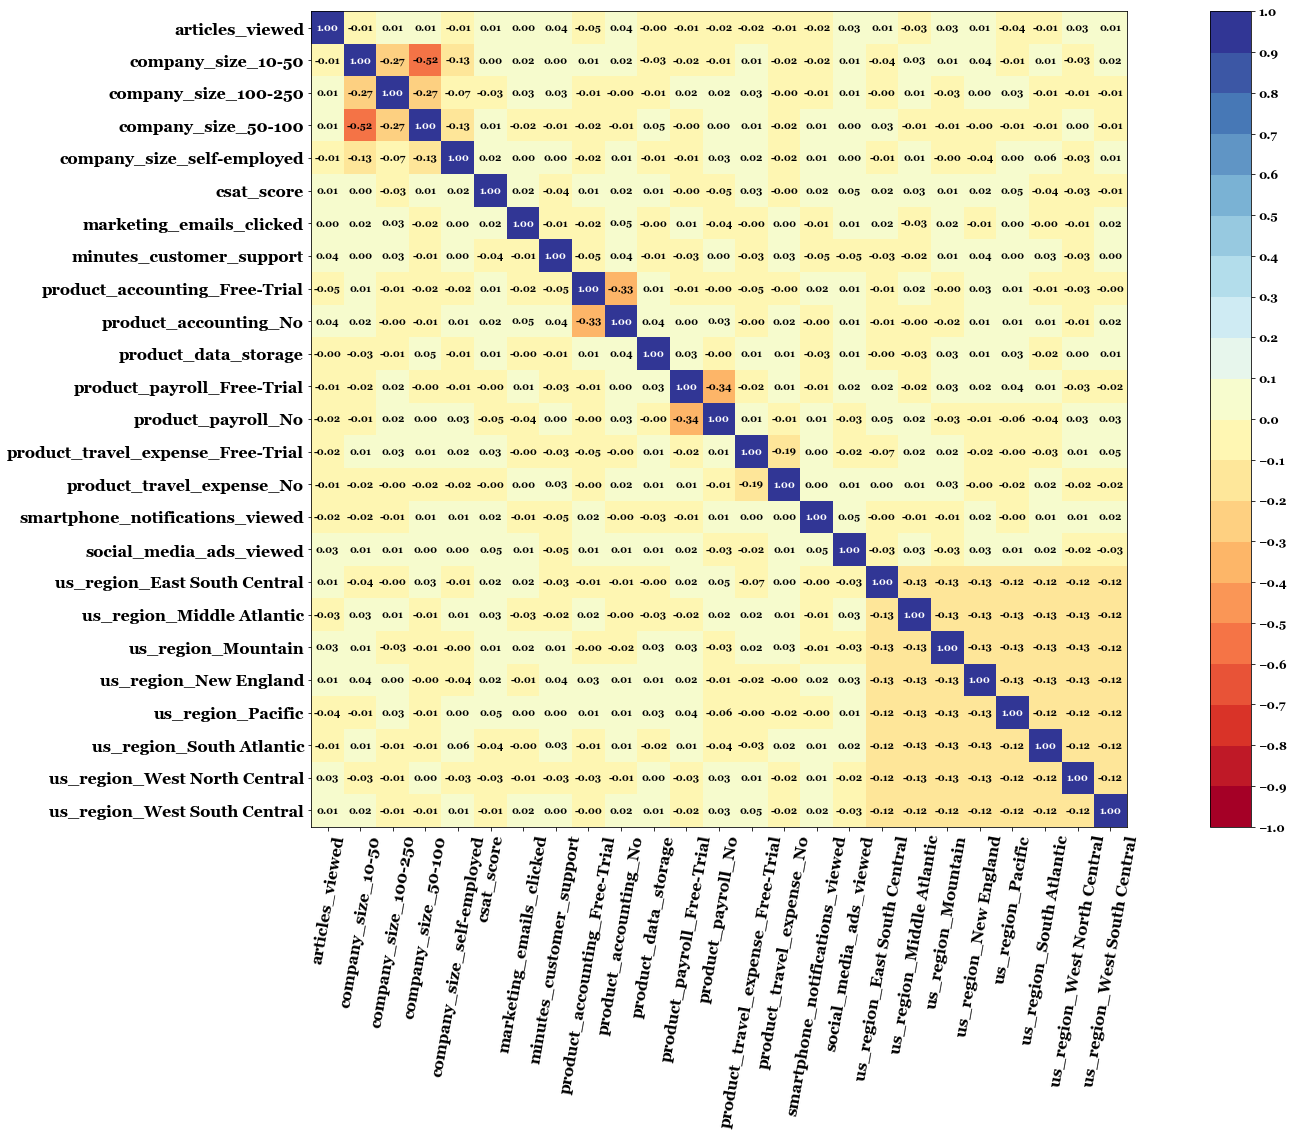

In [23]:
from pysurvival.utils.display import correlation_matrix
correlation_matrix(data[features], figure_size=(30,15), text_fontsize=10)

In [27]:
N = data.shape[0]

# Building training and testing sets
from sklearn.model_selection import train_test_split
index_train, index_test = train_test_split(range(N), test_size = 0.25)
data_train = data.loc[index_train].reset_index( drop = True )
data_test  = data.loc[index_test].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

In [59]:
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel

# Fitting the model
csf = ConditionalSurvivalForestModel(num_trees=1200)
csf.fit(X_train, T_train, E_train, max_features='all',
        max_depth=5, min_node_size=20, alpha=0.05, minprop=0.1, num_threads=6)

ConditionalSurvivalForestModel

In [60]:
# Computing variables importance
csf.variable_importance_table.head(10)

,feature,importance,pct_importance
0,csat_score,232.858899,0.367319
1,product_payroll_No,174.002436,0.274477
2,product_accounting_No,73.158433,0.115402
3,minutes_customer_support,61.500610,0.097013
4,product_payroll_Free-Trial,35.459649,0.055935
5,product_data_storage,15.978571,0.025205
6,product_travel_expense_Free-Trial,14.157461,0.022332
7,smartphone_notifications_viewed,9.869921,0.015569
8,product_accounting_Free-Trial,4.579730,0.007224
9,social_media_ads_viewed,4.501735,0.007101


In [35]:
E_train.value_counts()/len(E_train) * 100

0.0    53.466667
1.0    46.533333
Name: churned, dtype: float64

In [36]:
E_test.value_counts()/len(E_test) * 100

0.0    53.2
1.0    46.8
Name: churned, dtype: float64

In [62]:
from pysurvival.utils.metrics import concordance_index
c_index = concordance_index(csf, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index)) #0.83

C-index: 0.86


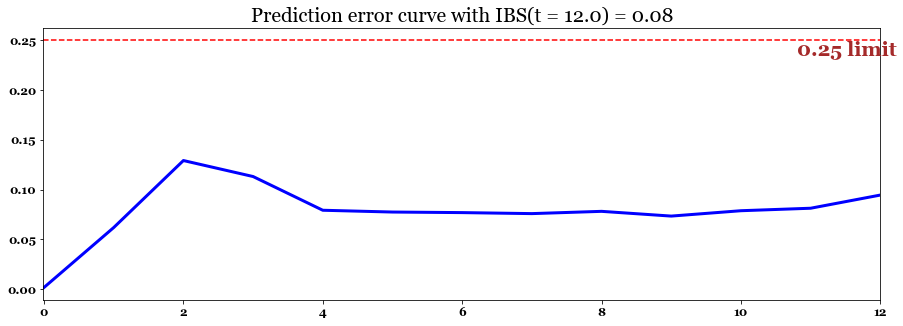

IBS: 0.08


In [61]:
from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(csf, X_test, T_test, E_test, t_max=12,
    figure_size=(15,5))
print('IBS: {:.2f}'.format(ibs))

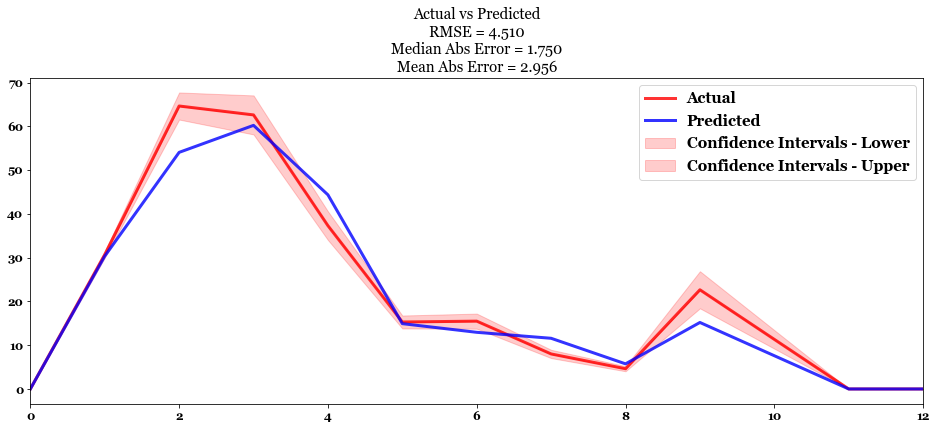

In [63]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(csf, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])

In [41]:
import pysurvival as pys

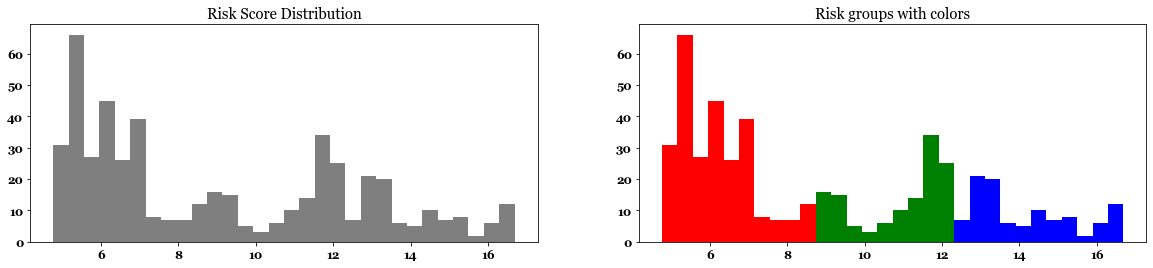

In [52]:
from pysurvival.utils.display import create_risk_groups

risk_groups = create_risk_groups(model=csf, X=X_test,
    use_log = False, num_bins=30, figure_size=(20, 4),
    low={'lower_bound':0, 'upper_bound':8.5, 'color':'red'},
    medium={'lower_bound':8.5, 'upper_bound':12.,'color':'green'},
    high={'lower_bound':12., 'upper_bound':25,  'color':'blue'}
    )

Text(4.0, 0.5, 'T=4.0')

Text(4.0, 0.6, 'T=4.0')

Text(2.0, 0.7, 'T=2.0')

Text(0.5, 1.0, 'Comparing Survival functions between low, medium, high risk grades')

(0.0, 1.05)

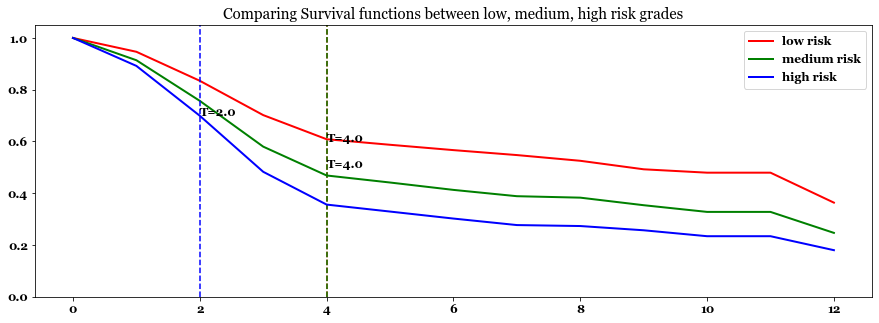

In [53]:
# Initializing the figure
fig, ax = plt.subplots(figsize=(15, 5))

# Selecting a random individual that experienced an event from each group
groups = []
for i, (label, (color, indexes)) in enumerate(risk_groups.items()) :

    # Selecting the individuals that belong to this group
    if len(indexes) == 0 :
        continue
    X = X_test.values[indexes, :]
    T = T_test.values[indexes]
    E = E_test.values[indexes]

    # Randomly extracting an individual that experienced an event
    choices = np.argwhere((E==1.)).flatten()
    if len(choices) == 0 :
        continue
    k = np.random.choice( choices, 1)[0]

    # Saving the time of event
    t = T[k]

    # Computing the Survival function for all times t
    survival = csf.predict_survival(X[k, :]).flatten()

    # Displaying the functions
    label_ = '{} risk'.format(label)
    plt.plot(csf.times, survival, color = color, label=label_, lw=2)
    groups.append(label)

    # Actual time
    plt.axvline(x=t, color=color, ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5*(1.+0.2*i)),
        xytext=(t, 0.5*(1.+0.2*i)), fontsize=12)

# Show everything
groups_str = ', '.join(groups)
title = "Comparing Survival functions between {} risk grades".format(groups_str)
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()

In [76]:
d = ['10   1.1   8   10  3.43   0.63   6.28   1.03   2.37   6.17  10  0.21   2.71   1.25  10   3.4  0.62   1.94   0.22   7.43   6.16  10  9.41  10  10']

In [78]:
vals = '.'.join(d).split('  ')

In [80]:
vals = [float(val.strip()) for val in vals]

In [83]:
sum(vals)/len(vals)

5.2944

In [84]:
np.mean(vals); np.median(vals)

5.2944

6.16

In [85]:
np.exp(0.09)

1.0941742837052104

In [86]:
np.exp(-0.43)

0.6505090947233165